In [28]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T

import numpy as np
import pylab as pl

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 16    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
BATCH_SIZE = 8
N_ITERS = 60           # Iterations before applying the loss
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

In [3]:
class CAModel(nn.Module):
    """Neural cellular automata model"""
    def __init__(self, n_channels=16, device=None, fire_rate=0.5):
        super().__init__()
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_channels = n_channels
        self.fire_rate = fire_rate
        
        self.layers = nn.Sequential(nn.Conv2d(n_channels*3, 128, 1),
                                    nn.ReLU(),
                                    nn.Conv2d(128, n_channels, 1))
        
    
    def wrap_edges(self, x):
        return F.pad(x, (1,1,1,1), 'circular', 0)

    
    def get_living_mask(self, x):
        alpha = x[:, 3:4, :, :]
        return F.max_pool2d(self.wrap_edges(alpha), 3, stride=1) > 0.1


    def perceive(self, x, angle=0.):
        identity = torch.tensor([[0.,0.,0.],
                                 [0.,1.,0.],
                                 [0.,0.,0.]])
        dx = torch.tensor([[-0.125,0.,0.125],
                           [-0.25 ,0.,0.25 ],
                           [-0.125,0.,0.125]])
        dy = dx.T
        
        angle = torch.tensor(angle)
        c, s = torch.cos(angle), torch.sin(angle)
        dx, dy = c*dx - s*dy, s*dx + c*dy
        
        
        all_filters = torch.stack((identity, dx, dy))
        all_filters_batch = all_filters.repeat(self.n_channels,1,1).unsqueeze(1)
        all_filters_batch = all_filters_batch.to(self.device)
        return F.conv2d(self.wrap_edges(x), all_filters_batch, groups=self.n_channels)
    

    def forward(self, x, angle=0., step_size=1.):
        pre_life_mask = self.get_living_mask(x)
        
        dx = self.layers(self.perceive(x, angle)) * step_size
        update_mask = torch.rand(x[:,:1,:,:].size(), device=self.device) < self.fire_rate
        x += dx*update_mask.float()
        
        post_life_mask = self.get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * life_mask.float()
    
    
    def evolve(self, x, iters, angle=0., step_size=1.):
        for i in range(iters):
            x = self.forward(x, angle=angle, step_size=step_size)
        
        return x

torch.Size([3, 3, 5, 5])

In [5]:
class SamplePool:
    """Samples the training images"""
    def __init__(self):
        image_size = TARGET_SIZE + TARGET_PADDING
        start_point = torch.zeros((POOL_SIZE, N_CHANNELS, image_size, image_size))
        start_point[:, 3, image_size//2, image_size//2] = 1.
        self.images = start_point
        self.size = POOL_SIZE

        
    def sample(self, batch_size):
        idx = np.random.choice(self.size, batch_size, False)
        return self.images[idx], idx
    
    def update(self, new_images, idx):
        self.images[idx] = new_images

        
def CenterCrop(image):
    """Center crops an image"""
    return T.CenterCrop(TARGET_SIZE)(image)

def imshow(image, center_crop=False):
    """Prints an image"""
    if center_crop:
        image = CenterCrop(image)
    pl.imshow(np.asarray(image.cpu().permute(1,2,0)[:,:,:4]))
    
    
pool = SamplePool()
imshow(pool.sample(1)[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


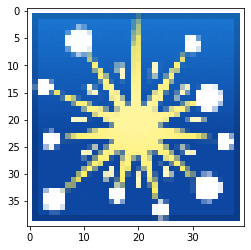

In [4]:
# Imports the target emoji
target = read_image("firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = target/255.

imshow(target)

In [7]:
class loss_fn:
    """Custom l2 loss function"""
    def __init__(self, order=2):
        self.order = order
        
    def __call__(x):
        return torch.mean(torch.abs(CenterCrop(x)[:, :4, :, :] - target)**self.order)

target = target.cpu()
loss_fn(pool.sample(16)[0])

tensor(0.5652)

In [8]:
# Send data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = CAModel().to(device)
pool = SamplePool()

In [9]:
#torch.save(model.state_dict(), "not_persistent.pt")
model.load_state_dict(torch.load("not_persistent.pt"))

<All keys matched successfully>

In [23]:
# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

model.train()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
losses = []
for i in range(2000):
    inputs, indexes = pool.sample(BATCH_SIZE)
    inputs = inputs.to(device)
    optimizer.zero_grad()
    
    for j in range(N_ITERS):
        inputs = model(inputs)
    
    loss = loss_fn(inputs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

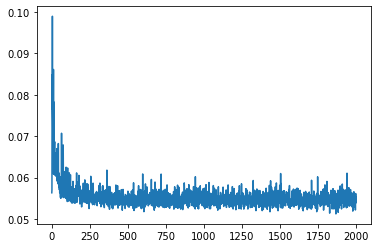

In [24]:
pl.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


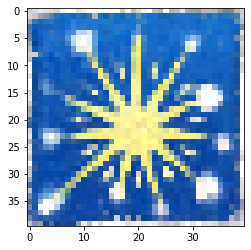

In [27]:
model.eval()

with torch.no_grad():
    x, _ = pool.sample(1)
    x = x.to(device)
    
    for j in range(N_ITERS):
        x = model(x)

        
imshow(x[0], center_crop=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


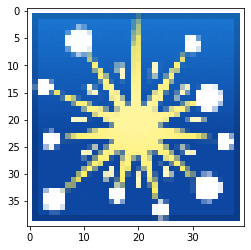

In [13]:
imshow(target)